## Gender Distinguished Analysis of ADHD v.s. Bipolar - by Yating Jing

Build models for female patients and male patients separately.

In [1]:
import pandas as pd
import numpy as np

df_adhd = pd.read_csv('ADHD_Gender_rCBF.csv')
df_bipolar = pd.read_csv('Bipolar_Gender_rCBF.csv')

n1, n2 = df_adhd.shape[0], df_bipolar.shape[0]

print 'Number of ADHD patients (without Bipolar) is', n1
print 'Number of Bipolar patients (without ADHD) is', n2
print 'Chance before gender separation is', float(n1) / (n1 + n2)

Number of ADHD patients (without Bipolar) is 1484
Number of Bipolar patients (without ADHD) is 471
Chance before gender separation is 0.759079283887


In [2]:
# Separate the genders
adhd1_id, adhd2_id = list(), list()
bipolar1_id, bipolar2_id = list(), list()

for i, g in df_adhd[['Patient_ID', 'Gender_id']].values:
    if g == 1:
        adhd1_id.append(i)
    elif g == 2:
        adhd2_id.append(i)
        
for i, g in df_bipolar[['Patient_ID', 'Gender_id']].values:
    if g == 1:
        bipolar1_id.append(i)
    elif g == 2:
        bipolar2_id.append(i)
        
print 'Number of Gender 1 ADHD patients (without Bipolar) is', len(adhd1_id)
print 'Number of Gender 2 ADHD patients (without Bipolar) is', len(adhd2_id)
print 'Number of Gender 1 Bipolar patients (without ADHD) is', len(bipolar1_id)
print 'Number of Gender 2 Bipolar patients (without ADHD) is', len(bipolar2_id)

Number of Gender 1 ADHD patients (without Bipolar) is 1017
Number of Gender 2 ADHD patients (without Bipolar) is 467
Number of Gender 1 Bipolar patients (without ADHD) is 242
Number of Gender 2 Bipolar patients (without ADHD) is 228


In [3]:
# Separate ADHD data gender-wise
df_adhd1 = df_adhd.loc[df_adhd['Patient_ID'].isin(adhd1_id)].drop(['Patient_ID', 'Gender_id'], axis=1)
df_adhd2 = df_adhd.loc[df_adhd['Patient_ID'].isin(adhd2_id)].drop(['Patient_ID', 'Gender_id'], axis=1)
# Separate Bipolar data gender-wise
df_bipolar1 = df_bipolar.loc[df_bipolar['Patient_ID'].isin(bipolar1_id)].drop(['Patient_ID', 'Gender_id'], axis=1)
df_bipolar2 = df_bipolar.loc[df_bipolar['Patient_ID'].isin(bipolar2_id)].drop(['Patient_ID', 'Gender_id'], axis=1)

# Create disorder labels for classification
# ADHD: 0, Bipolar: 1
n1_adhd, n1_bipolar = len(adhd1_id), len(bipolar1_id)
n2_adhd, n2_bipolar = len(adhd2_id), len(bipolar2_id)
# Labels for gender 1
y1 = [0] * n1_adhd + [1] * n1_bipolar  
# Labels for gender 2
y2 = [0] * n2_adhd + [1] * n2_bipolar 

print 'Shape check:'
print 'ADHD:', df_adhd1.shape, df_adhd2.shape
print 'Bipolar:', df_bipolar1.shape, df_bipolar2.shape

# Gender1 data
df1_all = pd.concat([df_adhd1, df_bipolar1], axis=0)
# Gender2 data
df2_all = pd.concat([df_adhd2, df_bipolar2], axis=0)

print '\nDouble shape check:'
print 'Gender 1:', df1_all.shape, len(y1)
print 'Gender 2:', df2_all.shape, len(y2)

# Compute chances 
chance1 = float(n1_adhd)/(n1_adhd + n1_bipolar)
chance2 = float(n2_adhd)/(n2_adhd + n2_bipolar)
print 'Chance for gender 1 is', chance1
print 'Chance for gender 2 is', chance2

Shape check:
ADHD: (1017, 256) (467, 256)
Bipolar: (242, 256) (228, 256)

Double shape check:
Gender 1: (1259, 256) 1259
Gender 2: (695, 256) 695
Chance for gender 1 is 0.80778395552
Chance for gender 2 is 0.671942446043


## Machine Learning Utilities

### K-Means Clustering

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def kmeans(df, title, k=4):
    data = df.values.T
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)

    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    
    fig = plt.figure()
    fig.suptitle('K-Means on '+title+' Features' , fontsize=14, fontweight='bold')
    
    # Plot clusters
    for i in range(k):
        # Extract observations within each cluster
        ds = data[np.where(labels==i)]
        # Plot the observations with symbol o
        plt.plot(ds[:,0], ds[:,1], 'o')
        # Plot the centroids with simbol x
        lines = plt.plot(centroids[i,0], centroids[i,1], 'x')
        plt.setp(lines, ms=8.0)
        plt.setp(lines, mew=2.0)

### Principal Component Analysis

In [5]:
from sklearn import preprocessing
from sklearn.decomposition import PCA

# Plot explained variance ratio
def plot_evr(ex_var_ratio):
    plt.title('Explained Variance Ratios by PCA')
    plt.plot(ex_var_ratio)
    plt.ylabel('Explained Variance Ratio')
    plt.xlabel('Principal Component')
    
def pca(df, n=20):
    '''
    Default number of principal components: 20
    '''
    # Scale
    X = df.values
    X_scaled = preprocessing.scale(X)
    # PCA
    pca = PCA(n_components=n)
    pc = pca.fit_transform(X_scaled)
    
    print '\nExplained Variance Ratios:'
    print pca.explained_variance_ratio_
    print '\nSum of Explained Variance Ratios of the first', n, 'components is', 
    print np.sum(pca.explained_variance_ratio_)
    
    plot_evr(pca.explained_variance_ratio_)

    return pc

### Locally Linear Embedding

In [6]:
from sklearn.manifold import LocallyLinearEmbedding

# Compute explained variance ratio of transformed data
def compute_explained_variance_ratio(transformed_data):
    explained_variance = np.var(transformed_data, axis=0)
    explained_variance_ratio = explained_variance / np.sum(explained_variance)
    explained_variance_ratio = np.sort(explained_variance_ratio)[::-1]
    return explained_variance_ratio

def lle(X, n=10):
    # Scale
    X_scaled = preprocessing.scale(X)
    # LLE
    lle = LocallyLinearEmbedding(n_neighbors=25, n_components=n, method='ltsa')
    pc = lle.fit_transform(X_scaled)
    ex_var_ratio = compute_explained_variance_ratio(pc)
    
    print '\nExplained Variance Ratios:'
    print ex_var_ratio
    # print '\nSum of Explained Variance Ratios of ', n, 'components is', 
    # print np.sum(ex_var_ratio)
    
    return pc

### Classification

In [7]:
from sklearn import cross_validation
from sklearn.cross_validation import KFold

def train_test_clf(clf, clf_name, X, y, k=10):
    '''
    Train and test a classifier using # K-fold cross validation
    Args:
        clf: sklearn classifier
        clf_name: classifier name (for printing)
        X: training data (2D numpy matrix)
        y: labels (1D vector)
        k: number of folds (default=10)
    '''
    kf = KFold(len(X), n_folds=k)
    scores = cross_validation.cross_val_score(clf, X, y, cv=kf)
    acc, acc_std = scores.mean(), scores.std()
    print clf_name + ' accuracy is %0.4f (+/- %0.3f)' % (acc, acc_std)
    return acc, acc_std

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.lda import LDA
from sklearn.qda import QDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier

def classify(X, y, gender, feature_type):
    lg = LogisticRegression(penalty='l2')
    knn = KNeighborsClassifier(n_neighbors=7)
    svc = LinearSVC()
    lda = LDA()
    qda = QDA()
    rf = RandomForestClassifier(n_estimators=30) 
    gb = GradientBoostingClassifier(n_estimators=20, max_depth=3)
    et = ExtraTreesClassifier(n_estimators=40, max_depth=5)
    ada = AdaBoostClassifier()

    classifiers = [lg, knn, svc, lda, qda, rf, gb, et, ada]
    clf_names = ['Logistic Regression', 'KNN', 'Linear SVM', 'LDA', 'QDA', \
                 'Random Forest', 'Gradient Boosting', 'Extra Trees', 'AdaBoost']
    accuracies = list()
    
    for clf, name in zip(classifiers, clf_names):
        acc, acc_std = train_test_clf(clf, name, X, y)
        accuracies.append(acc)
        
    # Visualize classifier performance
    x = range(len(accuracies))
    width = 0.6/1.5
    plt.bar(x, accuracies, width)
    
    # Compute chance
    n0, n1 = y.count(0), y.count(1)
    chance = max(n0, n1) / float(n0 + n1)
    
    fig_title = gender + ' Classifier Performance on ' + feature_type + ' features'
    plt.title(fig_title)
    plt.xticks(x, clf_names, rotation=50)
    plt.xlabel('Classifier')
    plt.gca().xaxis.set_label_coords(1.1, -0.025)
    plt.ylabel('Accuracy')
    plt.axhline(chance, color='red', linestyle='--', label='chance') # plot chance
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.85))

## Gender 1 ADHD v.s. Bipolar Analysis

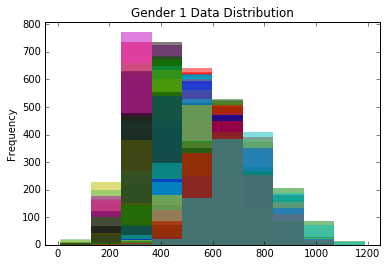

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

plot = df1_all.plot(kind='hist', alpha=0.5, title='Gender 1 Data Distribution', legend=None)

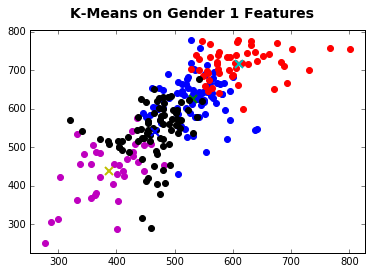

In [10]:
# Cluster Gender 1 rCBF features
kmeans(df1_all, 'Gender 1')


Explained Variance Ratios:
[ 0.67898313  0.09083259  0.05443272  0.02162001  0.01647434  0.01415119
  0.0092877   0.0084366   0.00787463  0.00583563  0.00578811  0.00453004
  0.00429468  0.00369701  0.0034384   0.00292809  0.00242601  0.0023285
  0.00222657  0.00203969]

Sum of Explained Variance Ratios of the first 20 components is 0.94162565908


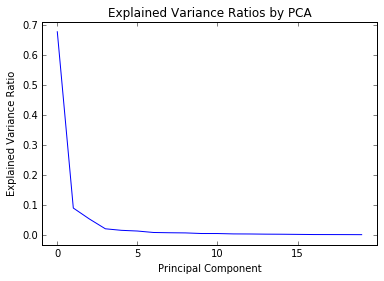

In [11]:
# PCA 
X1_pca = pca(df1_all, 20)

In [12]:
# LLE 
X1_lle = lle(df1_all, 20) 


Explained Variance Ratios:
[ 0.05066643  0.05066561  0.05066455  0.05063971  0.05061845  0.05061456
  0.05044154  0.05044111  0.05041049  0.05036976  0.05034345  0.050317
  0.05020545  0.05017253  0.05011076  0.05008773  0.05006648  0.04954995
  0.04693316  0.04668128]


Using PCA features:
Logistic Regression accuracy is 0.8008 (+/- 0.381)
KNN accuracy is 0.7730 (+/- 0.368)
Linear SVM accuracy is 0.8056 (+/- 0.385)
LDA accuracy is 0.8000 (+/- 0.379)
QDA accuracy is 0.7516 (+/- 0.346)
Random Forest accuracy is 0.7984 (+/- 0.380)
Gradient Boosting accuracy is 0.8032 (+/- 0.384)
Extra Trees accuracy is 0.8071 (+/- 0.386)
AdaBoost accuracy is 0.7516 (+/- 0.341)


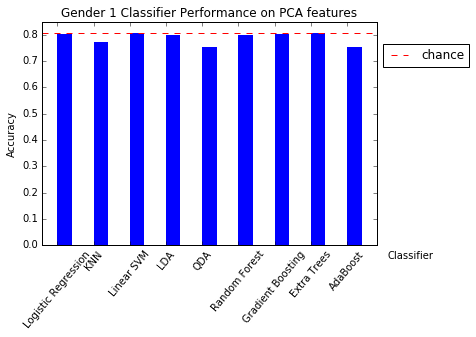

In [13]:
# Classification using PCA features
print 'Using PCA features:'
classify(X1_pca, y1, 'Gender 1', 'PCA')

Using LLE features:
Logistic Regression accuracy is 0.8071 (+/- 0.386)
KNN accuracy is 0.7754 (+/- 0.370)
Linear SVM accuracy is 0.8071 (+/- 0.386)
LDA accuracy is 0.8095 (+/- 0.379)
QDA accuracy is 0.9793 (+/- 0.037)
Random Forest accuracy is 0.8032 (+/- 0.384)
Gradient Boosting accuracy is 0.8040 (+/- 0.381)
Extra Trees accuracy is 0.8048 (+/- 0.383)
AdaBoost accuracy is 0.8048 (+/- 0.379)


/Library/Python/2.7/site-packages/sklearn/lda.py:161: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Python/2.7/site-packages/sklearn/qda.py:124: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


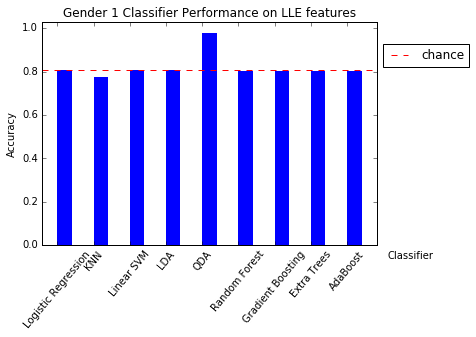

In [14]:
# Classification using LLE features
print 'Using LLE features:'
classify(X1_lle, y1, 'Gender 1', 'LLE')

## Gender 2 ADHD v.s. Bipolar Analysis

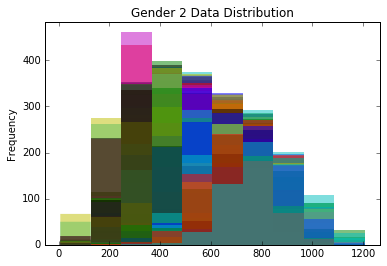

In [15]:
plot = df2_all.plot(kind='hist', alpha=0.5, title='Gender 2 Data Distribution', legend=None)

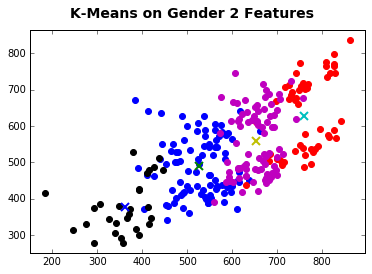

In [16]:
# Cluster Gender 2 rCBF features
kmeans(df2_all, 'Gender 2')


Explained Variance Ratios:
[ 0.5654925   0.09867097  0.08267282  0.03296176  0.02625313  0.02156537
  0.01485341  0.01327306  0.00921992  0.00821073  0.00778259  0.0061064
  0.00576132  0.0054138   0.00524185  0.00430654  0.00390861  0.00361252
  0.00348766  0.00308828]

Sum of Explained Variance Ratios of the first 20 components is 0.921883253062


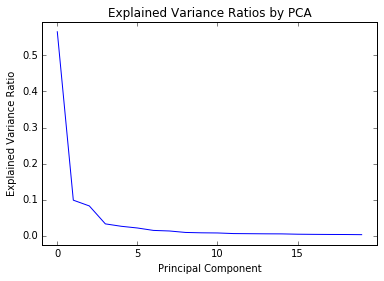

In [17]:
# PCA
X2_pca = pca(df2_all, 20)

In [18]:
# LLE
X2_lle = lle(df2_all, 20) 


Explained Variance Ratios:
[ 0.05003478  0.05003478  0.05003478  0.05003478  0.05003478  0.05003478
  0.05003478  0.05003478  0.05003478  0.05003478  0.05003478  0.05003277
  0.05003041  0.05002718  0.05002708  0.05002324  0.05000892  0.04998043
  0.04975022  0.0497372 ]


Using PCA features:
Logistic Regression accuracy is 0.6138 (+/- 0.401)
KNN accuracy is 0.5469 (+/- 0.281)
Linear SVM accuracy is 0.6167 (+/- 0.402)
LDA accuracy is 0.6166 (+/- 0.403)
QDA accuracy is 0.5554 (+/- 0.276)
Random Forest accuracy is 0.6066 (+/- 0.388)
Gradient Boosting accuracy is 0.6380 (+/- 0.415)
Extra Trees accuracy is 0.6696 (+/- 0.447)
AdaBoost accuracy is 0.5324 (+/- 0.267)


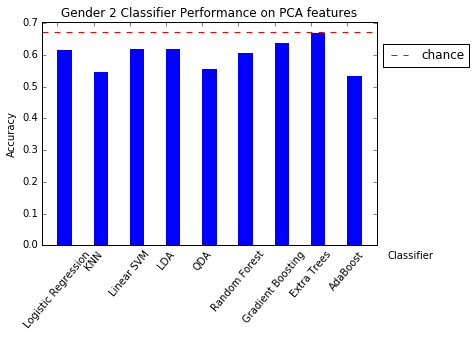

In [19]:
# Classification using PCA features
print 'Using PCA features:'
classify(X2_pca, y2, 'Gender 2', 'PCA')

Using LLE features:
Logistic Regression accuracy is 0.6696 (+/- 0.447)
KNN accuracy is 0.5523 (+/- 0.320)
Linear SVM accuracy is 0.6681 (+/- 0.446)
LDA accuracy is 0.6610 (+/- 0.433)
QDA accuracy is 0.7609 (+/- 0.392)
Random Forest accuracy is 0.5881 (+/- 0.370)
Gradient Boosting accuracy is 0.6553 (+/- 0.436)
Extra Trees accuracy is 0.6754 (+/- 0.435)
AdaBoost accuracy is 0.5493 (+/- 0.342)


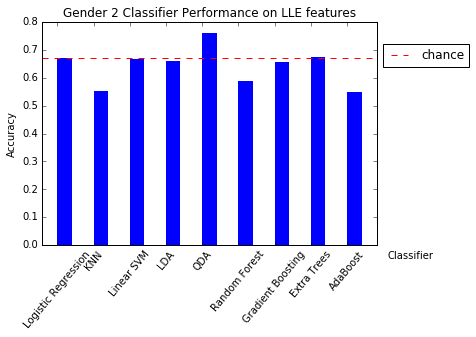

In [20]:
# Classification using LLE features
print 'Using LLE features:'
classify(X2_lle, y2, 'Gender 2', 'LLE')

### Conclusion

QDA with LLE features finally does much better than chance! \\(^o^)/

It seems that non-linear classifiers on features extracted using manifold learning would work for this problem.


#### Next Step:

- Need to look into the warning for gender 1 classification. 
- The accuracy for gender 1 is suspiciously high, need to check each step to make sure there is no mistakes.
- Tune parameters for existing classifiers.
- Try new methods for both feature construction and classification.
- I have some doubts about the dimensionality reduction and train-test procedure.